In [1]:
%load_ext autoreload
%autoreload 2

In [353]:
import numpy as np
from analysis.ngram import calculate_avg_ll
from analysis.plot_utils import plt, legend_opts, savefig
from matplotlib.animation import FuncAnimation

In [460]:
def calculate_avg_ln(prob_matrix, weights=None):
    return calculate_avg_ll(prob_matrix, weights, log_function=np.log)

## Combine models sequentially

In [454]:
train_prob_matrix = np.load('../data/train_prob_matrix.npy')
dev1_prob_matrix = np.load('../data/dev1_prob_matrix.npy')
dev2_prob_matrix = np.load('../data/dev2_prob_matrix.npy')

In [455]:
dev_prob_matrix = np.vstack([dev1_prob_matrix, dev2_prob_matrix])
dev_prob_matrix.shape

(803176, 6)

In [461]:
train_avg_lls = []
dev1_avg_lls = []
dev2_avg_lls = []
dev_avg_lls = []
labels = []
label = ''

ngram_combo = []
for n in range(6):
    ngram_combo.append(n)
    train_avg_lls.append(calculate_avg_ln(train_prob_matrix[:, ngram_combo]))
    dev1_avg_lls.append(calculate_avg_ln(dev1_prob_matrix[:, ngram_combo]))
    dev2_avg_lls.append(calculate_avg_ln(dev2_prob_matrix[:, ngram_combo]))
    dev_avg_lls.append(calculate_avg_ln(dev_prob_matrix[:, ngram_combo]))
    
    label += f'{n}\n'
    labels.append(label)
labels[0] = '0\n(uniform)'

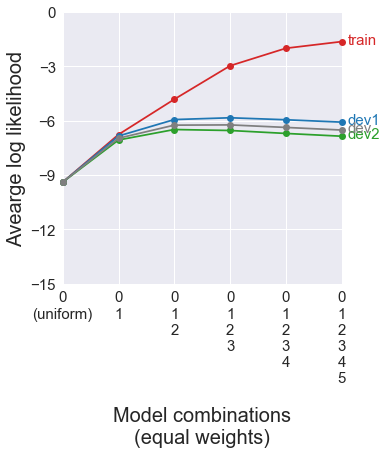

In [463]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(ngram_combo, train_avg_lls, '-o', color='tab:red', clip_on=False)
ax.plot(ngram_combo, dev1_avg_lls, '-o', color='tab:blue', clip_on=False)
ax.plot(ngram_combo, dev2_avg_lls, '-o', color='tab:green', clip_on=False)
ax.plot(ngram_combo, dev_avg_lls, '-o', color='tab:gray', clip_on=False)

ax.text(5.1, train_avg_lls[-1]+0.1, s='train', va='center', color='tab:red', fontsize=15)
ax.text(5.1, dev1_avg_lls[-1]+0.1, s='dev1', va='center', color='tab:blue', fontsize=15)
ax.text(5.1, dev2_avg_lls[-1]+0.1, s='dev2', va='center', color='tab:green', fontsize=15)
ax.text(5.1, dev_avg_lls[-1]+0.1, s='dev', va='center', color='tab:gray', fontsize=15)

ax.set_xticklabels(labels)
ax.set_xlabel('Model combinations\n(equal weights)')
ax.set_ylabel('Avearge log likelihood')
ax.set_xlim(0, 5)
ax.set_ylim(-15, 0)
ax.set_yticks(range(-15, 1, 3))
plt.show()

savefig(fig, 'what_to_combine.png')

## Interpolating 2 models

In [518]:
unigram_weights = np.linspace(0.0001, 1-0.0001, 100)
dev1_avg_lls = []
dev2_avg_lls = []
dev_avg_lls = []

for unigram_weight in unigram_weights:
    dev1_avg_lls.append(calculate_avg_ln(dev1_prob_matrix[:, [0, 1]], weights=[1-unigram_weight, unigram_weight]))
    dev2_avg_lls.append(calculate_avg_ln(dev2_prob_matrix[:, [0, 1]], weights=[1-unigram_weight, unigram_weight]))
    dev_avg_lls.append(calculate_avg_ln(dev_prob_matrix[:, [0, 1]], weights=[1-unigram_weight, unigram_weight]))

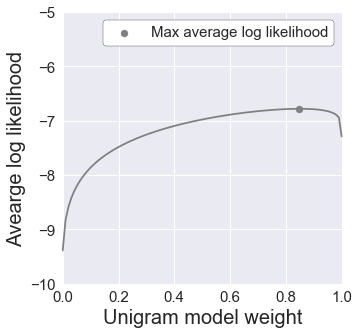

In [638]:
fig, ax = plt.subplots(figsize=(5, 5))

# ax.plot(unigram_weights, dev1_avg_lls, color='tab:blue', clip_on=False)
# ax.plot(unigram_weights, dev2_avg_lls, color='tab:green', clip_on=False)
ax.plot(unigram_weights, dev_avg_lls, color='tab:gray', clip_on=False)

# ax.scatter(unigram_weights[np.argmax(dev1_avg_lls)], np.max(dev1_avg_lls), color='tab:blue', clip_on=False)
# ax.scatter(unigram_weights[np.argmax(dev2_avg_lls)], np.max(dev2_avg_lls), color='tab:green', clip_on=False)
ax.scatter(unigram_weights[np.argmax(dev_avg_lls)], np.max(dev_avg_lls), color='tab:gray', clip_on=False, label='Max average log likelihood')

ax.set_xlim(0, 1)
ax.set_ylim(-10, -5)
ax.legend(**legend_opts)
ax.set_xlabel('Unigram model weight')
ax.set_ylabel('Avearge log likelihood')

savefig(fig, 'avg_ll_two_models.png')

## Gradient descent

Stand-alone function

In [526]:
def gradient_descent(prob_matrix, learning_rate, n_iter):
    # 1. Initialize all models to have the same weights
    n_models = prob_matrix.shape[1]
    weights = np.ones(n_models) / n_models
    
    ngram_probs = prob_matrix[:, 1:]
    uniform_prob = prob_matrix[:, [0]]

    for iteration in range(n_iter):
        # 2. Calculate gradients for each n-gram model
        interpolated_probs = np.sum(prob_matrix * weights, axis=1, keepdims=True)
        ngram_gradients = np.mean((ngram_probs - uniform_prob) / interpolated_probs, axis=0)
        
        # 3. Update interpolation weights for all models
        weights[1:] += learning_rate * ngram_gradients
        weights[0] = 1 - sum(weights[1:])
        
    return weights

Class to store intermediate values (for animation)

In [527]:
class GradientDescent:
    def __init__(self, track_iteration=True):
        self.track_iteration = track_iteration
        
    def fit(self, prob_matrix, learning_rate, n_iter=100):
        if self.track_iteration:
            self.tracked_info = {}
            
        n_models = prob_matrix.shape[1]
        self.weights = np.ones(n_models) / n_models

        uniform_prob = prob_matrix[:, [0]]
        ngram_probs = prob_matrix[:, 1:]
        for iteration in range(n_iter):
            interpolated_probs = np.sum(prob_matrix * self.weights, axis=1, keepdims=True)
            gradients = np.mean((ngram_probs - uniform_prob) / interpolated_probs, axis=0)
            if self.track_iteration:
                self.tracked_info[iteration] = {'weights': self.weights.copy(),
                                                'gradients': gradients,
                                                'avg_ll': calculate_avg_ln(prob_matrix, self.weights)}
            self.weights[1:] += learning_rate * gradients
            self.weights[0] = 1 - self.weights[1:].sum()

In [528]:
n_iter = 11
gd = GradientDescent()
gd.fit(dev_prob_matrix[:, :2], learning_rate=0.1, n_iter=n_iter)
gd.weights

array([0.15013842, 0.84986158])

In [530]:
def update(fig, ax, iteration):
    fig.suptitle(f'Iteration {iteration}', fontsize=20)
    ax.lines = [ax.lines[0]]
    ax.collections = [ax.collections[0]]
        
    tangent_length = 0.15
    
    info = gd.tracked_info[iteration]
    unigram_weight = info['weights'][1]
    unigram_gradient = info['gradients'][0]
    avg_ll = info['avg_ll']
    lower_unigram_weight, upper_unigram_weight = unigram_weight - tangent_length, unigram_weight + tangent_length
    lower_ll, upper_ll = avg_ll - unigram_gradient * tangent_length, avg_ll + unigram_gradient * tangent_length
    ax.plot([lower_unigram_weight, upper_unigram_weight], [lower_ll, upper_ll], color='tab:orange')
    ax.vlines(unigram_weight, -10, avg_ll, colors='tab:orange', linestyles='dashed', linewidth=0.5)
    ax.scatter(unigram_weight, avg_ll, color='tab:orange')

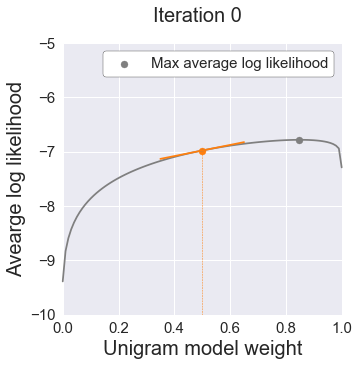

In [639]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(unigram_weights, dev_avg_lls, color='tab:gray', clip_on=False)
ax.scatter(unigram_weights[np.argmax(dev_avg_lls)], np.max(dev_avg_lls), color='tab:gray', clip_on=False, label='Max average log likelihood')
ax.set_xlim(0, 1)
ax.set_ylim(-10, -5)

ax.legend(**legend_opts)
ax.set_xlabel('Unigram model weight')
ax.set_ylabel('Avearge log likelihood')

anim = FuncAnimation(fig, lambda iteration: update(fig, ax, iteration), 
                     frames=range(n_iter), interval=300, repeat=True)
anim.save('../viz/gradient_descent.mp4', writer='ffmpeg')

## Expectation-maximation algorithm

### E-step

Log likelihood vs lower bound of average likelihood for first word in combined `dev` set

In [557]:
def calculate_lower_bound_ln(word_probs, true_weights, posterior_weights):
    with np.errstate(invalid='ignore'):
        lower_bound_components = posterior_weights * np.log(word_probs * true_weights / posterior_weights)
        lower_bound_components[np.isnan(lower_bound_components)] = 0
        lower_bound_ll = np.sum(lower_bound_components)
    return lower_bound_ll

Text(0, 0.5, 'Avearge log likelihood')

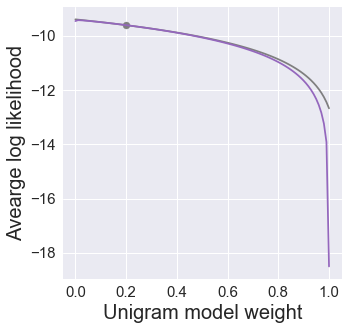

In [640]:
first_word_probs = dev_prob_matrix[[0], :2]
unigram_step_weight = 0.2
joint_probs = first_word_probs * [1 - unigram_step_weight, unigram_step_weight]
marginal_prob = np.sum(joint_probs)
posterior_weights = joint_probs / marginal_prob

first_word_lls = []
first_word_lower_bound_lls = []

unigram_weights = np.linspace(0.0001, 1-0.0001, 100)
for unigram_weight in unigram_weights:
    first_word_ll = calculate_avg_ln(first_word_probs, weights=[1-unigram_weight, unigram_weight])
    first_word_lls.append(first_word_ll)
    
    first_word_lower_bound_ll = calculate_lower_bound_ln(first_word_probs,
                                                         true_weights=[1-unigram_weight, unigram_weight],
                                                         posterior_weights=posterior_weights)
    first_word_lower_bound_lls.append(first_word_lower_bound_ll)
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(unigram_weights, first_word_lls, color='tab:gray', clip_on=False)
ax.plot(unigram_weights, first_word_lower_bound_lls, color='tab:purple', clip_on=False)
ax.scatter(unigram_step_weight, calculate_avg_ln(first_word_probs, weights=[1-unigram_step_weight, unigram_step_weight]), color='tab:gray', clip_on=False)

ax.set_xlabel('Unigram model weight')
ax.set_ylabel('Avearge log likelihood')

Average log likelihood vs lower bound of average likelihood for all words in combined `dev` set

In [641]:
def calculate_posterior_weights(prob_matrix, unigram_step_weight):
    joint_probs = prob_matrix * [1 - unigram_step_weight, unigram_step_weight]
    marginal_probs = np.sum(joint_probs, axis=1, keepdims=True)
    posterior_weights = joint_probs / marginal_probs
    return posterior_weights

In [652]:
def calculate_lower_bound_ln(prob_matrix, unigram_weight, unigram_step_weight):
    true_weights = [1 - unigram_weight, unigram_weight]
    posterior_weights = calculate_posterior_weights(prob_matrix, unigram_step_weight)
    with np.errstate(invalid='ignore'):
        lower_bound_components = posterior_weights * np.log(prob_matrix * true_weights / posterior_weights)
        lower_bound_components[np.isnan(lower_bound_components)] = 0
        lower_bound_ll = np.sum(lower_bound_components, axis=1)
        lower_bound_avg_ll = lower_bound_ll.mean()
    return lower_bound_avg_ll

In [656]:
dev_avg_lls = []
dev_lower_bound_avg_lls = []

unigram_weight0 = 0.2
avg_ll0 = calculate_avg_ln(dev_prob_matrix[:, [0, 1]], weights=[1-unigram_weight0, unigram_weight0])

unigram_weights = np.linspace(0.0001, 1-0.0001, 100)
objective_function = [calculate_avg_ln(dev_prob_matrix[:, [0, 1]], weights=[1-unigram_weight, unigram_weight]) for unigram_weight in unigram_weights]
argmax_objective_function, max_objective_function = unigram_weights[np.argmax(objective_function)], np.max(objective_function)

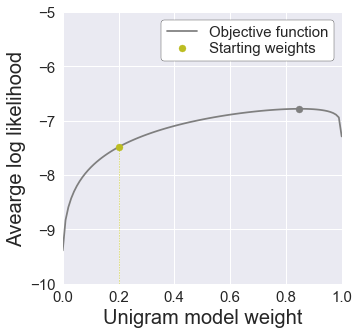

In [711]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(unigram_weights, objective_function, color='tab:gray', label='Objective function')
ax.scatter(argmax_objective_function, max_objective_function, color='tab:gray')
ax.scatter(unigram_weight0, avg_ll0,
           color='tab:olive', label='Starting weights', zorder=10)
ax.vlines(unigram_weight0, -10, avg_ll0, color='tab:olive', linestyles='dashed', linewidth=0.5)
ax.legend(**legend_opts)

ax.set_xlim(0, 1)
ax.set_ylim(-10, -5)
ax.set_xlabel('Unigram model weight')
ax.set_ylabel('Avearge log likelihood')
savefig(fig, 'e1.png')

In [662]:
lower_bound0 = [calculate_lower_bound_ln(dev_prob_matrix[:, [0, 1]], unigram_weight, unigram_weight0) for unigram_weight in unigram_weights]

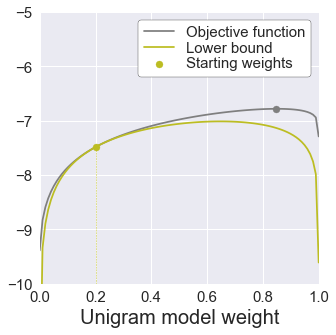

In [712]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(unigram_weights, objective_function, color='tab:gray', label='Objective function')
ax.scatter(argmax_objective_function, max_objective_function, color='tab:gray')
ax.scatter(unigram_weight0, avg_ll0,
           color='tab:olive', label='Starting weights', zorder=10)
ax.vlines(unigram_weight0, -10, avg_ll0, color='tab:olive', linestyles='dashed', linewidth=0.5)

ax.plot(unigram_weights, lower_bound0, color='tab:olive', label='Lower bound')
ax.legend(**legend_opts)

ax.set_xlim(0, 1)
ax.set_ylim(-10, -5)
ax.set_xlabel('Unigram model weight')
# ax.set_ylabel('Avearge log likelihood')
savefig(fig, 'e2.png')

In [664]:
argmax_lower_bound0, max_lower_bound0 = unigram_weights[np.argmax(lower_bound0)], np.max(lower_bound0)

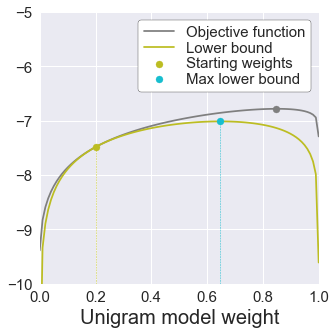

In [713]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(unigram_weights, objective_function, color='tab:gray', label='Objective function')
ax.scatter(argmax_objective_function, max_objective_function, color='tab:gray')
ax.scatter(unigram_weight0, avg_ll0,
           color='tab:olive', label='Starting weights', zorder=10)
ax.vlines(unigram_weight0, -10, avg_ll0, color='tab:olive', linestyles='dashed', linewidth=0.5)

ax.plot(unigram_weights, lower_bound0, color='tab:olive', label='Lower bound')

ax.scatter(argmax_lower_bound0, max_lower_bound0,
           color='tab:cyan', label='Max lower bound', zorder=10)
ax.vlines(argmax_lower_bound0, -10, max_lower_bound0, color='tab:cyan', linestyles='dashed', linewidth=0.5)

ax.legend(**legend_opts)

ax.set_xlim(0, 1)
ax.set_ylim(-10, -5)
ax.set_xlabel('Unigram model weight')
# ax.set_ylabel('Avearge log likelihood')
savefig(fig, 'e3.png')

In [703]:
unigram_weight1 = argmax_lower_bound0
lower_bound1 = [calculate_lower_bound_ln(dev_prob_matrix[:, [0, 1]], unigram_weight, unigram_weight1) for unigram_weight in unigram_weights]
avg_ll1 = calculate_avg_ln(dev_prob_matrix[:, [0, 1]], weights=[1-unigram_weight1, unigram_weight1])
argmax_lower_bound1, max_lower_bound1 = unigram_weights[np.argmax(lower_bound1)], np.max(lower_bound1)

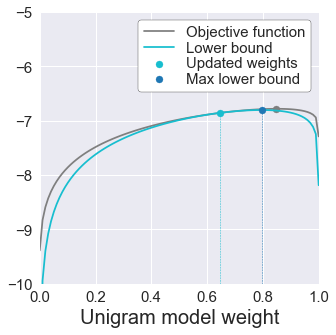

In [714]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(unigram_weights, objective_function, color='tab:gray', label='Objective function')
ax.scatter(argmax_objective_function, max_objective_function, color='tab:gray')

ax.scatter(unigram_weight1, avg_ll1,
           color='tab:cyan', label='Updated weights', zorder=10)
ax.vlines(argmax_lower_bound0, -10, avg_ll1, color='tab:cyan', linestyles='dashed', linewidth=0.5)
ax.plot(unigram_weights, lower_bound1, color='tab:cyan', label='Lower bound')

ax.scatter(argmax_lower_bound1, max_lower_bound1,
           color='tab:blue', label='Max lower bound', zorder=10)
ax.vlines(argmax_lower_bound1, -10, max_lower_bound1, color='tab:blue', linestyles='dashed', linewidth=0.5)

ax.legend(**legend_opts)

ax.set_xlim(0, 1)
ax.set_ylim(-10, -5)
ax.set_xlabel('Unigram model weight')
# ax.set_ylabel('Avearge log likelihood')
savefig(fig, 'e4.png')

### EM algorithm

In [423]:
def get_em_weights(prob_matrix, n_iter=50):
    n_models = prob_matrix.shape[1]
    weights = np.ones(n_models) / n_models

    for i in range(n_iter):
        weighted_probs = prob_matrix * weights
        total_probs = weighted_probs.sum(axis=1, keepdims=True)

        # E-step
        posterior_probs = weighted_probs / total_probs

        # M-step
        weights = posterior_probs.mean(axis=0)
    return weights

In [424]:
dev_weights = get_em_weights(dev_prob_matrix)

In [427]:
dev_weights

array([1.56348314e-01, 3.43914715e-01, 4.31647987e-01, 6.51445688e-02,
       2.94441562e-03, 2.53999735e-10])

Average log likelihood vs lower bound of average likelihood for all words in combined `dev` set

In [17]:
def calculate_posterior_weights(prob_matrix, unigram_step_weight):
    joint_probs = prob_matrix * [1 - unigram_step_weight, unigram_step_weight]
    marginal_probs = np.sum(joint_probs, axis=1, keepdims=True)
    posterior_weights = joint_probs / marginal_probs
    return posterior_weights

In [18]:
def calculate_lower_bound_avg_ll(prob_matrix, true_weights, posterior_weights):
    with np.errstate(invalid='ignore'):
        lower_bound_components = posterior_weights * np.log(prob_matrix * true_weights / posterior_weights)
        lower_bound_components[np.isnan(lower_bound_components)] = 0
        lower_bound_ll = np.sum(lower_bound_components, axis=1)
        lower_bound_avg_ll = lower_bound_ll.mean()
    return lower_bound_avg_ll

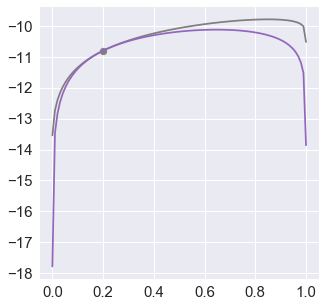

In [19]:
dev_avg_lls = []
dev_lower_bound_avg_lls = []

unigram_step_weight = 0.2
unigram_weights = np.linspace(0.0001, 1-0.0001, 100)
posterior_weights = calculate_posterior_weights(dev_prob_matrix[:, [0, 1]], unigram_step_weight)

for unigram_weight in unigram_weights:
    dev_avg_ll = calculate_avg_ln(dev_prob_matrix[:, [0, 1]], weights=[1-unigram_weight, unigram_weight])
    dev_avg_lls.append(dev_avg_ll)
    
    dev_lower_bound_avg_ll = calculate_lower_bound_avg_ll(dev_prob_matrix[:, [0, 1]],
                                                         true_weights=[1-unigram_weight, unigram_weight],
                                                         posterior_weights=posterior_weights)
    dev_lower_bound_avg_lls.append(dev_lower_bound_avg_ll)
    
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(unigram_weights, dev_avg_lls, color='tab:gray', clip_on=False)
ax.plot(unigram_weights, dev_lower_bound_avg_lls, color='tab:purple', clip_on=False)
ax.scatter(unigram_step_weight, calculate_avg_ln(dev_prob_matrix[:, [0, 1]], weights=[1-unigram_step_weight, unigram_step_weight]), color='tab:gray', clip_on=False)

### EM algorithm

In [21]:
dev_weights = get_em_weights(dev_prob_matrix[:, [0, 1]])

In [22]:
dev_weights

array([0.14949361, 0.85050639])